In [1]:
!pip install torch
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scipy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean
from torch.utils.data import Dataset, DataLoader

# Import Custom Activation Layers
import sys
sys.path.insert(0, '..')
from activationLayers import *

# Import RMHD Equations
from RMHDEquations import *

In [3]:
# Set device
device = torch.device("mps") #("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


In [4]:
# Custom Neural Network
class RMHDPINN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden, hidden_width, activation=TrainableTanh(), output_projection=FinalActivation()):
        super(RMHDPINN, self).__init__()
        
        self.input_dim = input_size
        self.output_dim = output_size
        self.hidden_dim = hidden_width
        self.num_layers = n_hidden
        
        # Define U and V layers separately
        self.U_layer = nn.Linear(input_size, hidden_width)
        self.V_layer = nn.Linear(input_size, hidden_width)
        
        # Define hidden and output layers
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_width, hidden_width) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_width, output_size)
        
        # Set activation function
        self.phi = activation
        self.output_projection = output_projection
        
    def forward(self, t, x):
        t = t.unsqueeze(1) if len(t.shape) == 1 else t
        x = x.unsqueeze(1) if len(x.shape) == 1 else x
        X = torch.cat([x, t], dim=1)
        U_t = self.phi(self.U_layer(X))
        V_t = self.phi(self.V_layer(X))
        H = U_t  # initial value for H

        for layer in self.hidden_layers:
            Z = self.phi(layer(H))
            H = (1 - Z) * U_t + Z * V_t

        output = self.output_layer(H)
        # Print the shape of the tensor before it's passed to the FinalActivation

        return output


# Initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [5]:
# Hyperparameters
depth = 4
width = 16
activation = FinalActivation()
model = RMHDPINN(input_size=2, output_size=5, n_hidden=depth, hidden_width=width, activation=TrainableTanh(), output_projection=activation).to(device)
print(model)
model(torch.rand(10,device=device), torch.rand(10,device=device))

RMHDPINN(
  (U_layer): Linear(in_features=2, out_features=16, bias=True)
  (V_layer): Linear(in_features=2, out_features=16, bias=True)
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=16, out_features=16, bias=True)
  )
  (output_layer): Linear(in_features=16, out_features=5, bias=True)
  (phi): TrainableTanh()
  (output_projection): FinalActivation()
)


tensor([[-0.0162,  0.1883,  0.0729,  0.1637,  0.1323],
        [-0.0103,  0.1603,  0.0829,  0.1464,  0.1216],
        [ 0.0061,  0.2123,  0.1506, -0.0107,  0.0963],
        [-0.0140,  0.1678,  0.1064,  0.1014,  0.1100],
        [-0.0152,  0.1751,  0.1013,  0.1103,  0.1143],
        [-0.0061,  0.1160,  0.1201,  0.0811,  0.0950],
        [ 0.0061,  0.0335,  0.1767, -0.0112,  0.0548],
        [ 0.0284,  0.2330,  0.1798, -0.0766,  0.0863],
        [ 0.0096,  0.0198,  0.1611,  0.0120,  0.0677],
        [ 0.0127,  0.0081,  0.1621,  0.0094,  0.0678]], device='mps:0',
       grad_fn=<LinearBackward0>)

In [6]:
def initial_condition(x):
    condition1 = torch.tensor([1.0,0.0,1.0,0.0,1.0], device=device)
    condition2 = torch.tensor([0.125,0.0,-1.0,0.0,0.1], device=device)
    newx = torch.flatten(x).to(device)
    return torch.outer(newx<0, condition1) + torch.outer(newx>=0, condition2)

In [7]:
def gradients(outputs, inputs, order = 1, device=device):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1) # Recursively take gradients
    else:
        return outputs

def rmhd_residual(pred,t,x):
    u_t= gradients(conserved_alfredo(pred),t)
    u_x= gradients(currents_alfredo(pred),x)
    return u_t + u_x


def random_domain(num_samples, t_range, x_range):
    t_random = torch.zeros(size=(num_samples, 1), device=device).uniform_(*t_range)
    x_random = torch.zeros(size=(num_samples, 1), device=device).uniform_(*x_range)
    t_random.requires_grad = True
    x_random.requires_grad = True
    return t_random, x_random



def random_boundary(num_samples, t_range, x_range, initial_to_boundary_ratio = 0.5):
    num_initial = int(initial_to_boundary_ratio * num_samples)
    num_boundary = num_samples - num_initial
    t_min, t_max = t_range

    # Generate initial condition samples
    t_initial = torch.zeros(size=(num_initial, 1), device=device)
    x_initial = torch.zeros(size=(num_initial, 1), device=device).uniform_(*x_range)
    u_initial = initial_condition(x_initial)

    # Generate boundary condition samples
    t_boundary = torch.zeros(size=(num_boundary, 1), device=device).uniform_(*t_range)

    # We assume x_range = (-1, 1) here
    x_boundary = 2 * torch.randint(0, 2, size=(num_boundary, 1), device=device) - 1
    u_boundary = initial_condition(x_boundary)#np.zeros((num_boundary, 1))

    return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
           torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)


In [8]:
lr = 0.001
model = RMHDPINN(input_size=2, output_size=5, n_hidden=depth, hidden_width=width, activation=TrainableTanh(), output_projection=activation).to(device)
#model = PINN(input_size=2, output_size=5, n_hidden=depth, hidden_width=width, activation=activation)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-4)
boundary_criterion = nn.MSELoss()
initial_criterion = nn.MSELoss()
domain_criterion = nn.MSELoss()
intermediate_criterion = nn.MSELoss()

In [9]:
num_epochs = 3000
model.train()

x_range, t_range = [-1, 1], [0, 1]
loss_history = []
domain_loss_history = []
initial_loss_history = []
boundary_loss_history = []
a_history = []
b_history = []
c_history = []
gradient_history = []

# Initialize lambda values
lambda_initial = 1.0
lambda_boundary = 1.0

max_schedule_steps = 1000
n = 100
for epoch in range(1, num_epochs + 1, max_schedule_steps):
    n += 7
    domain_samples = n**2
    for g in optimizer.param_groups:
        g['lr'] *= 3/4
    for step in range(0, max_schedule_steps):
        boundary_samples = 300  # You can change this value

        optimizer.zero_grad()
        
        domain_t, domain_x = random_domain(domain_samples, t_range, x_range)
        initial_t, initial_x, initial_u, boundary_t, boundary_x, boundary_u = random_boundary(boundary_samples, t_range, x_range, 0.5)
        domain_prediction = model(domain_t, domain_x)
        domain_residual = rmhd_residual(domain_prediction, domain_t, domain_x)
        initial_prediction = model(initial_t, initial_x)
        boundary_prediction = model(boundary_t, boundary_x)

        domain_loss = domain_criterion(domain_residual, torch.zeros_like(domain_residual))
        initial_loss = initial_criterion(initial_prediction, initial_u)
        boundary_loss = boundary_criterion(boundary_prediction, boundary_u)

        # # Step 3: Compute total loss and backpropagate
        loss = 10*domain_loss + lambda_initial * initial_loss + lambda_boundary * boundary_loss

        # Compute backward and update model parameters as usual
        loss.backward()
        optimizer.step()
        
        current_grads = [p.grad.clone() for p in model.parameters()]
        gradient_history.append(current_grads)
        
        loss_history.append(loss.item())
        domain_loss_history.append(domain_loss.item())
        initial_loss_history.append(initial_loss.item())
        boundary_loss_history.append(boundary_loss.item())

        
        if (epoch+step) % 100 == 0:
            print(f"Epoch: {epoch+step}, Loss: {loss}")

/var/folders/69/qsgfh7hj7csg_x4f7kcm2p9r0000gq/T/ipykernel_14206/2172649982.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
/var/folders/69/qsgfh7hj7csg_x4f7kcm2p9r0000gq/T/ipykernel_14206/2172649982.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)


Epoch: 100, Loss: 0.28771740198135376
Epoch: 200, Loss: 0.14189381897449493
Epoch: 300, Loss: 0.14674954116344452
Epoch: 400, Loss: 0.1235985979437828
Epoch: 500, Loss: 0.14424970746040344
Epoch: 600, Loss: 0.17627273499965668
Epoch: 700, Loss: 0.11985944956541061
Epoch: 800, Loss: 0.11424925923347473
Epoch: 900, Loss: 0.10406769812107086
Epoch: 1000, Loss: 0.12069244682788849
Epoch: 1100, Loss: 0.10208024829626083
Epoch: 1200, Loss: 0.11580085009336472
Epoch: 1300, Loss: 0.10521267354488373
Epoch: 1400, Loss: 0.09301437437534332
Epoch: 1500, Loss: 0.11514314264059067
Epoch: 1600, Loss: 0.09712431579828262
Epoch: 1700, Loss: 0.09742429852485657
Epoch: 1800, Loss: 0.10269646346569061
Epoch: 1900, Loss: 0.10128052532672882
Epoch: 2000, Loss: 0.0756104588508606
Epoch: 2100, Loss: 0.10469011962413788
Epoch: 2200, Loss: 0.09478065371513367
Epoch: 2300, Loss: 0.083088718354702
Epoch: 2400, Loss: 0.09573033452033997
Epoch: 2500, Loss: 0.09006468206644058
Epoch: 2600, Loss: 0.08343765884637833

In [10]:
model(domain_t, domain_x)

tensor([[ 0.2557, -0.0077, -0.7002,  0.0035,  0.1385],
        [ 0.6894,  0.0079, -0.2157,  0.0672,  0.4347],
        [ 0.7949,  0.0342, -0.1289,  0.0829,  0.4856],
        ...,
        [ 0.4133,  0.0120, -0.5600,  0.0412,  0.2470],
        [ 0.6123, -0.0415, -0.0938,  0.0486,  0.4700],
        [ 0.8962,  0.0240,  0.0207,  0.0861,  0.5680]], device='mps:0',
       grad_fn=<LinearBackward0>)

ValueError: not enough values to unpack (expected 2, got 1)

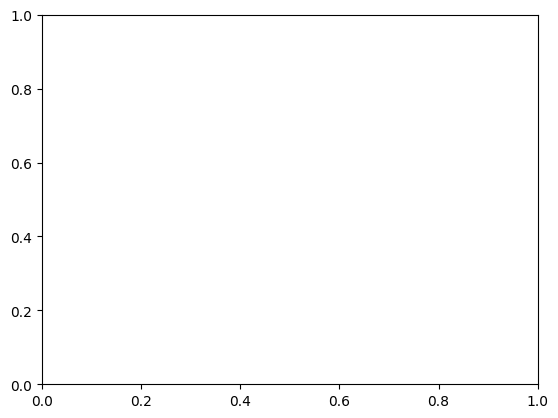